# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
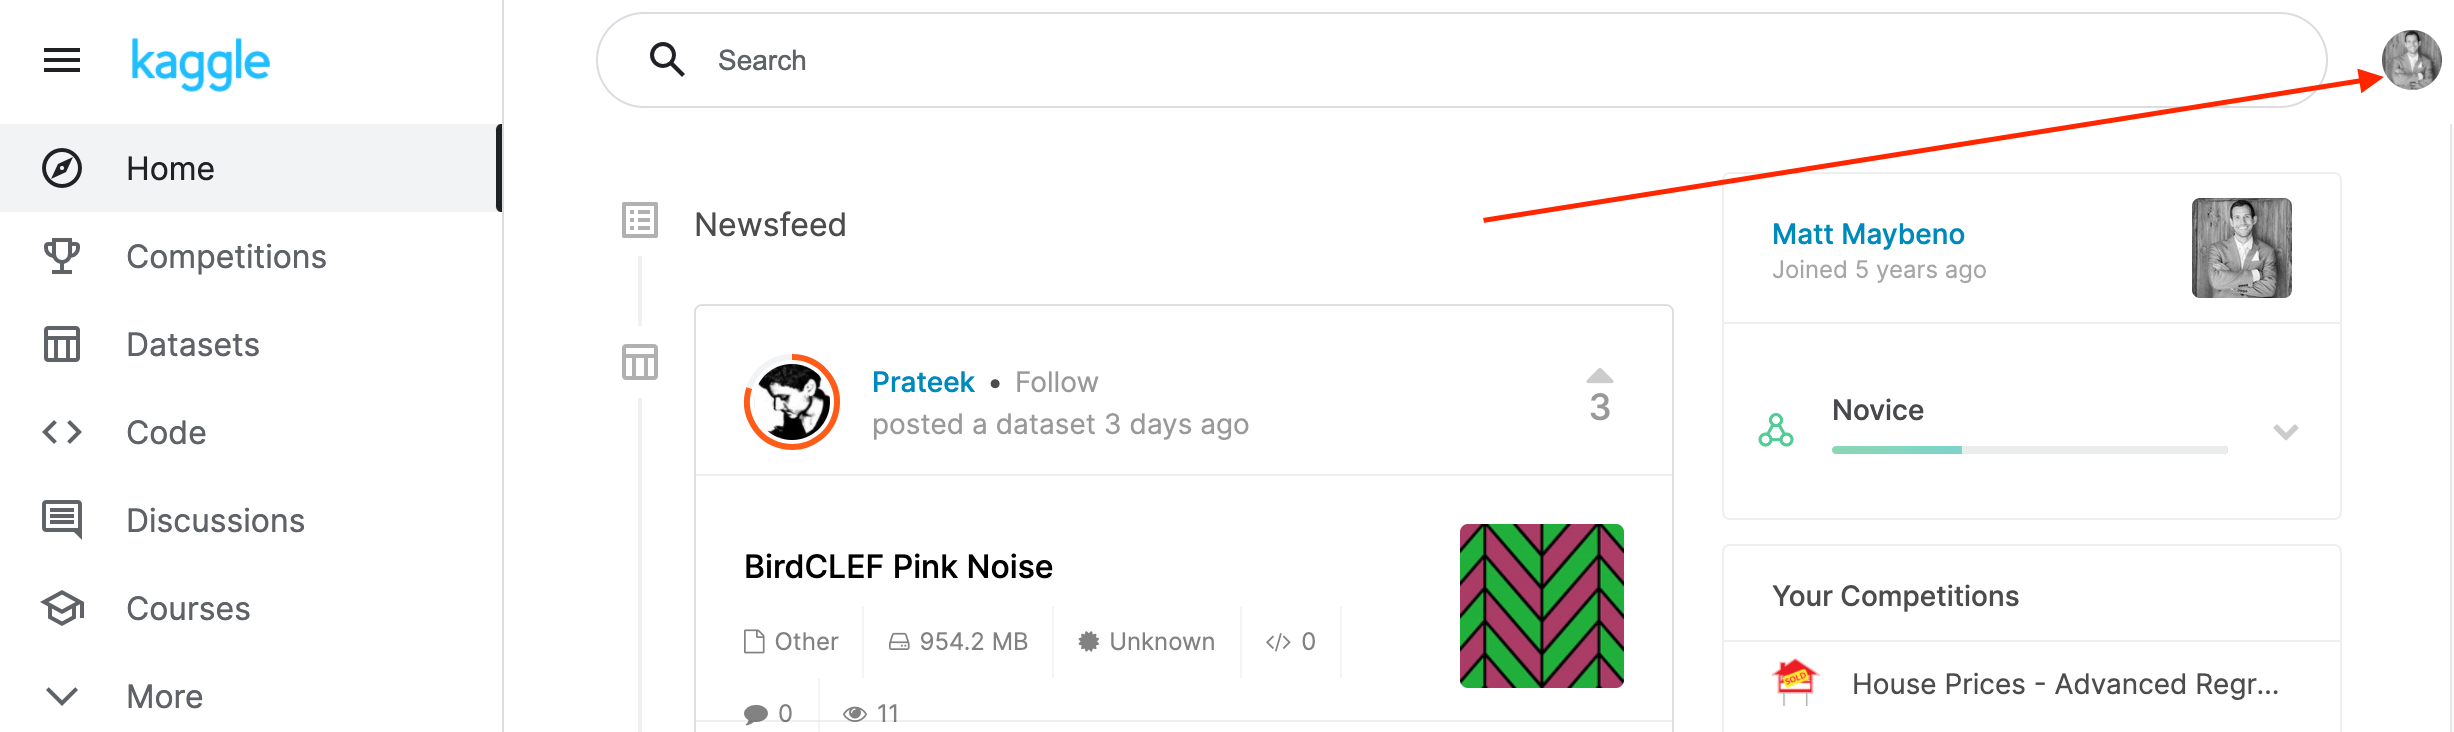
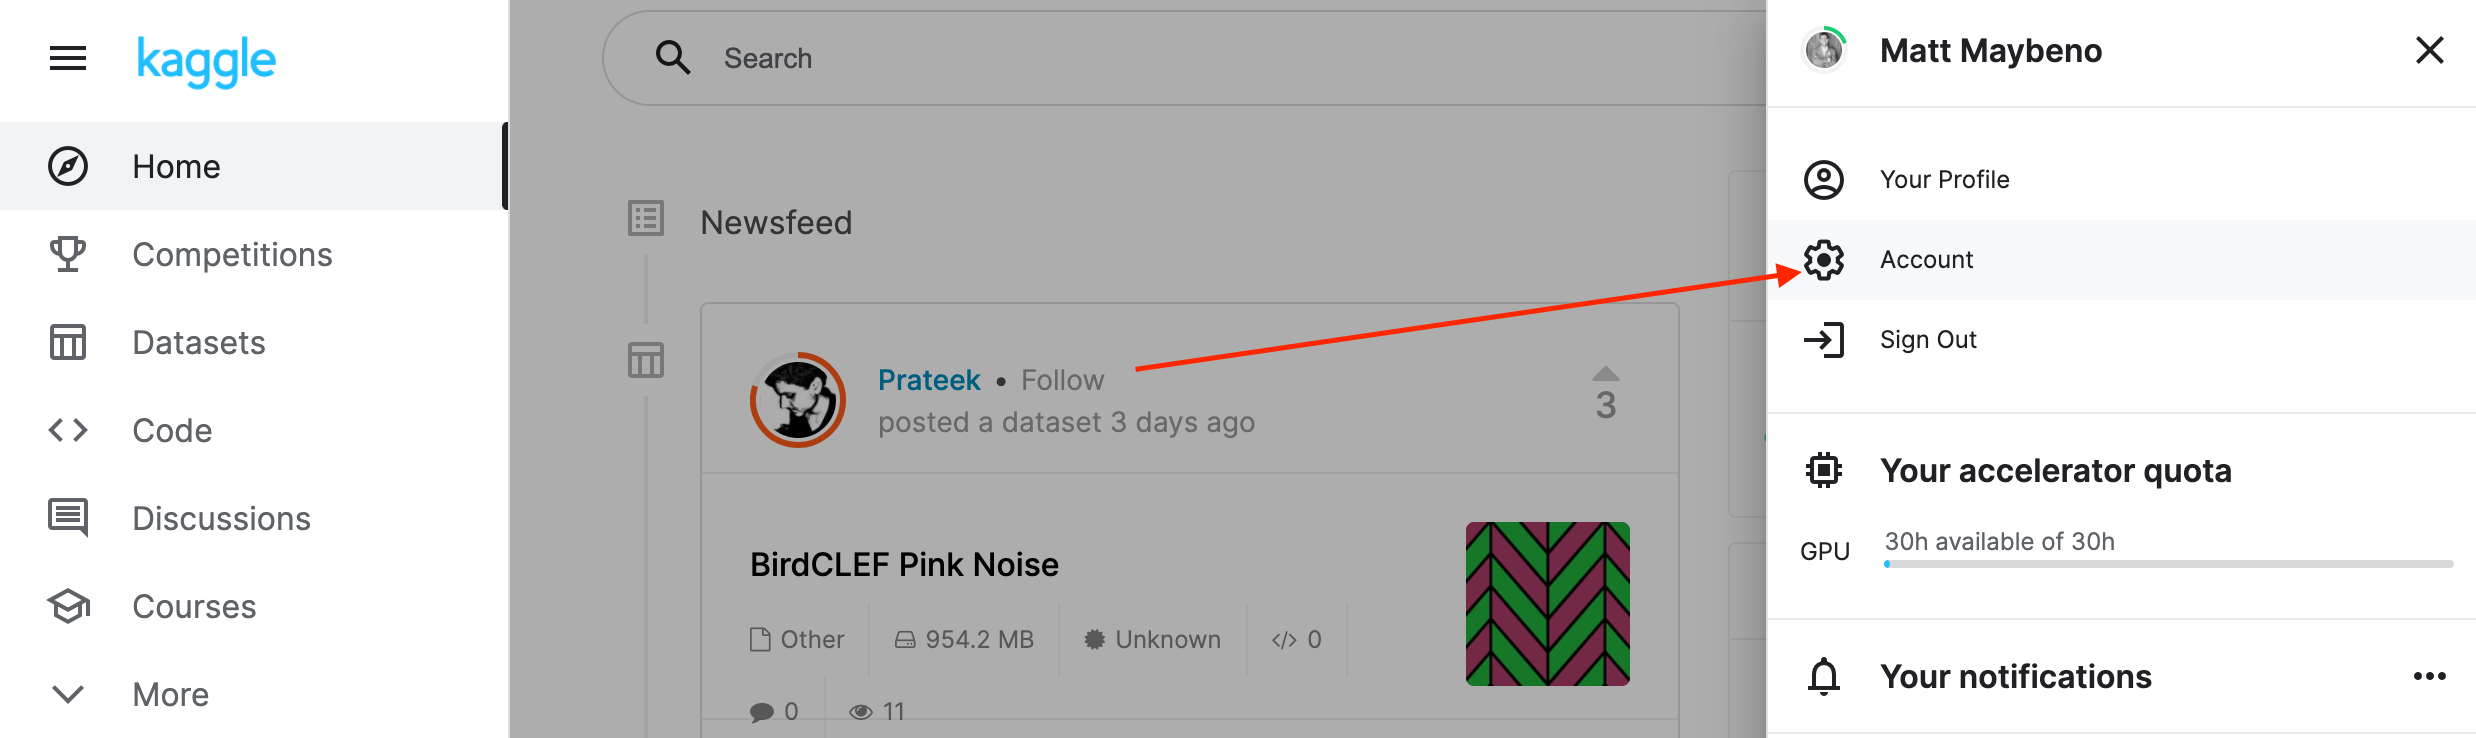
2. Scroll down to API and click Create New API Token.
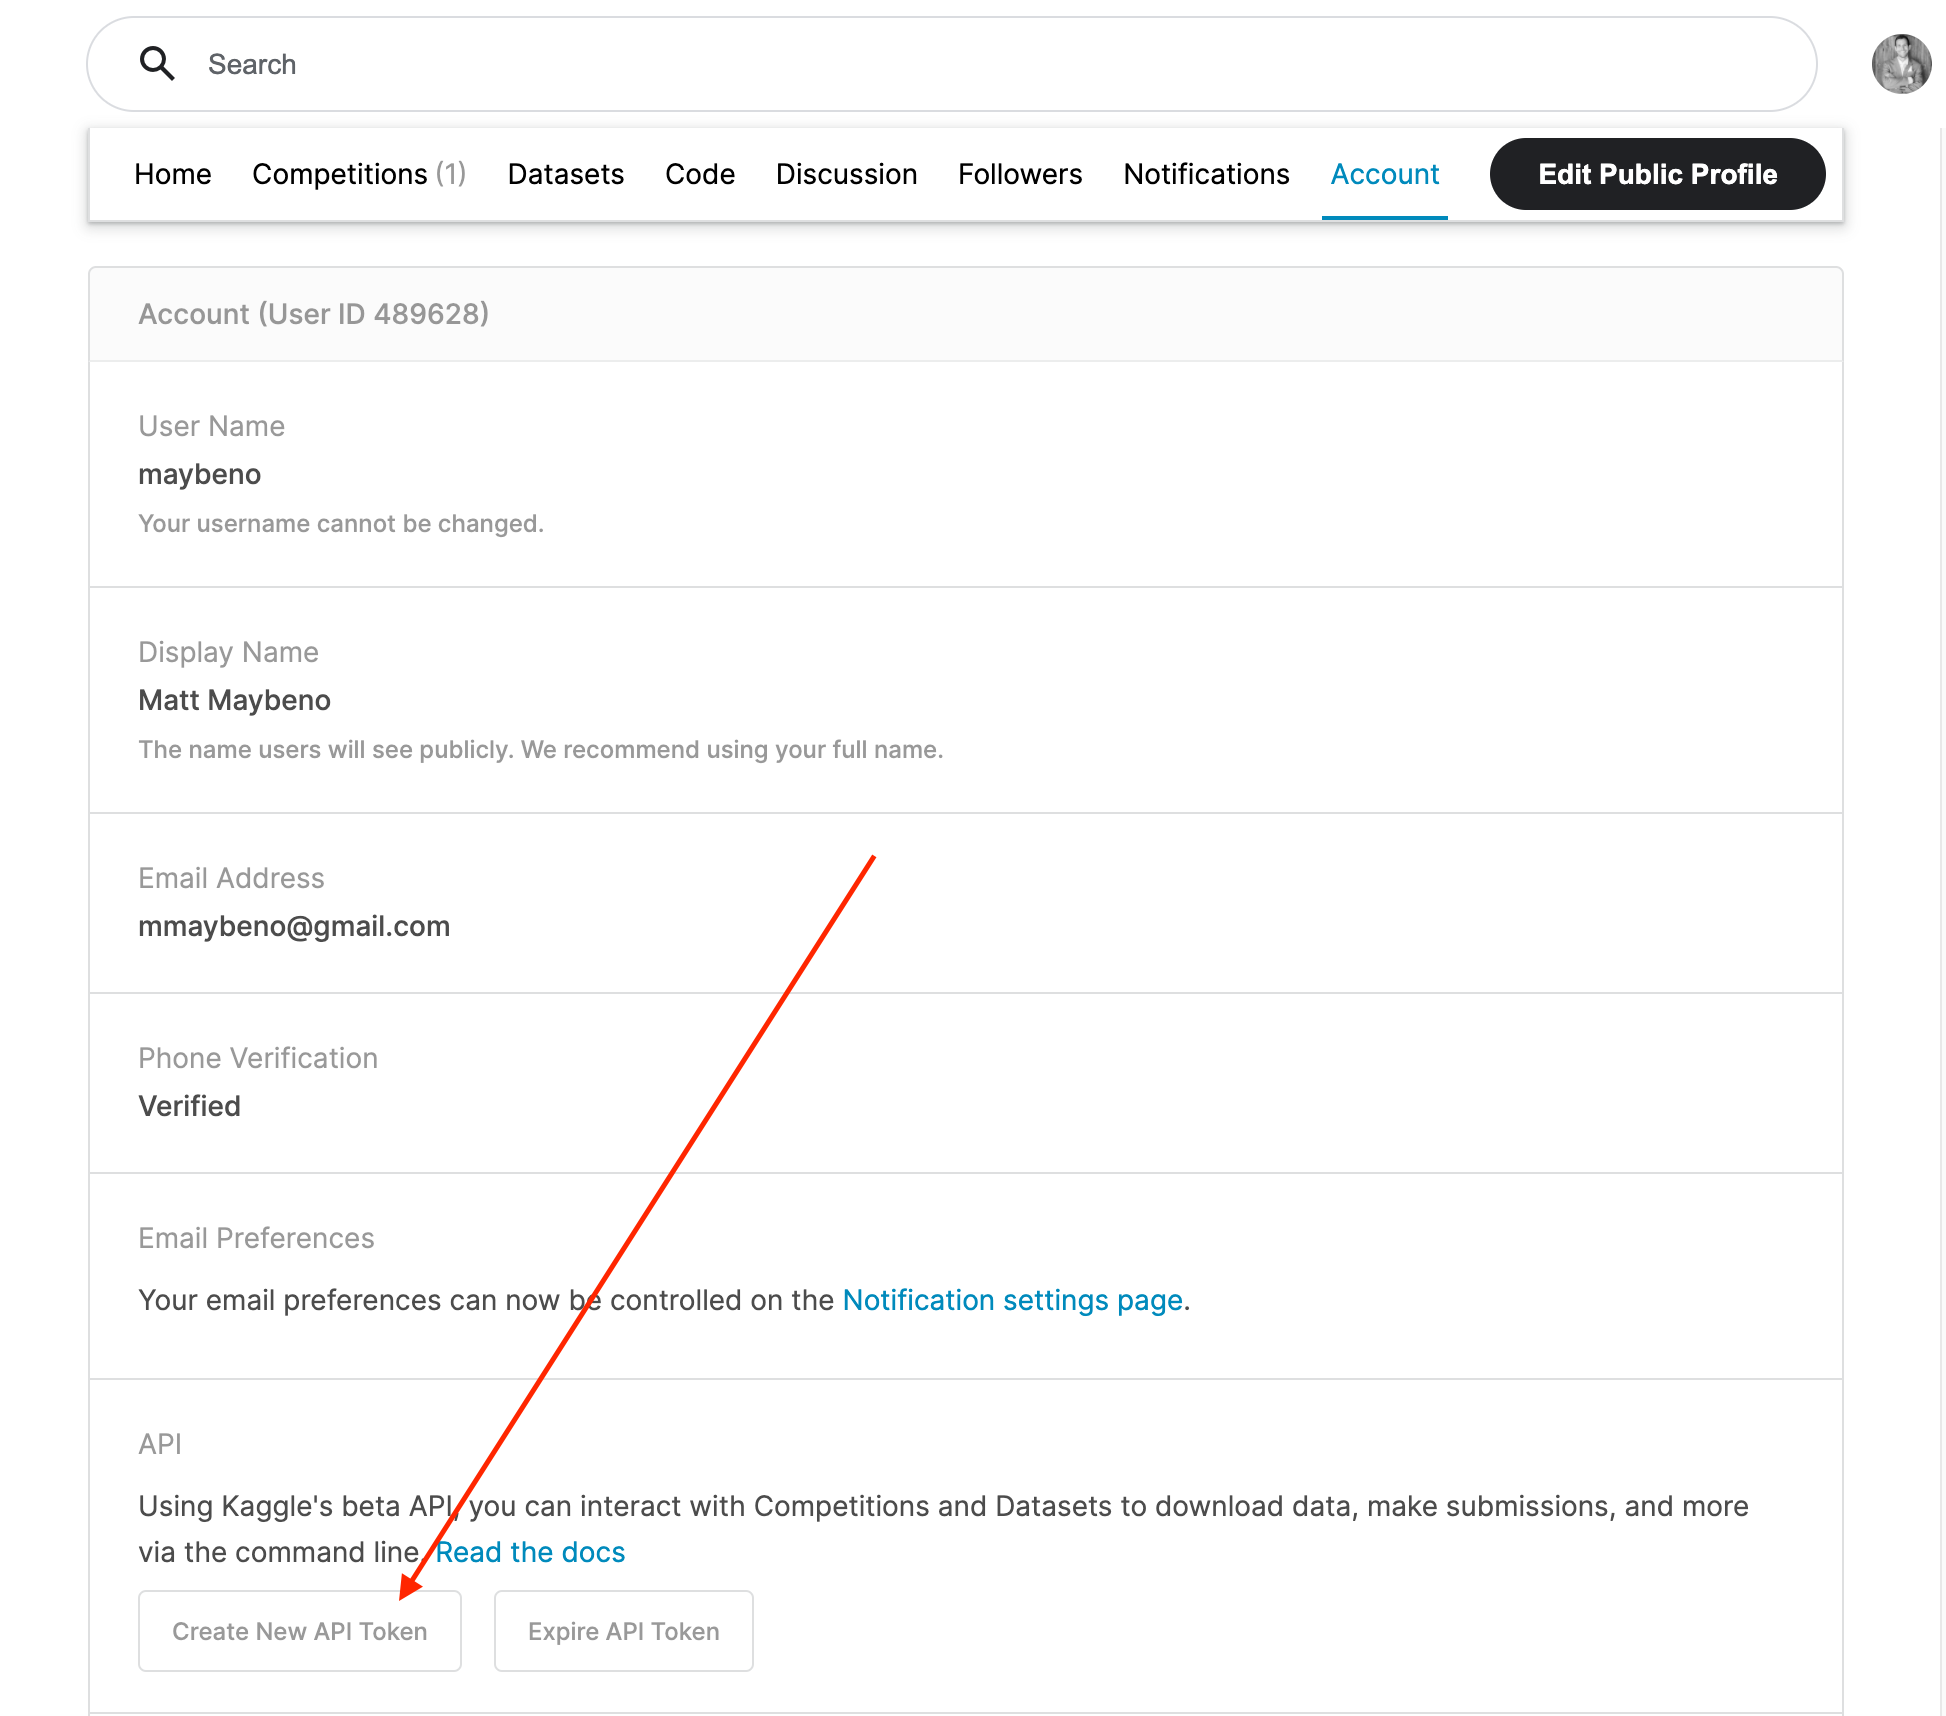
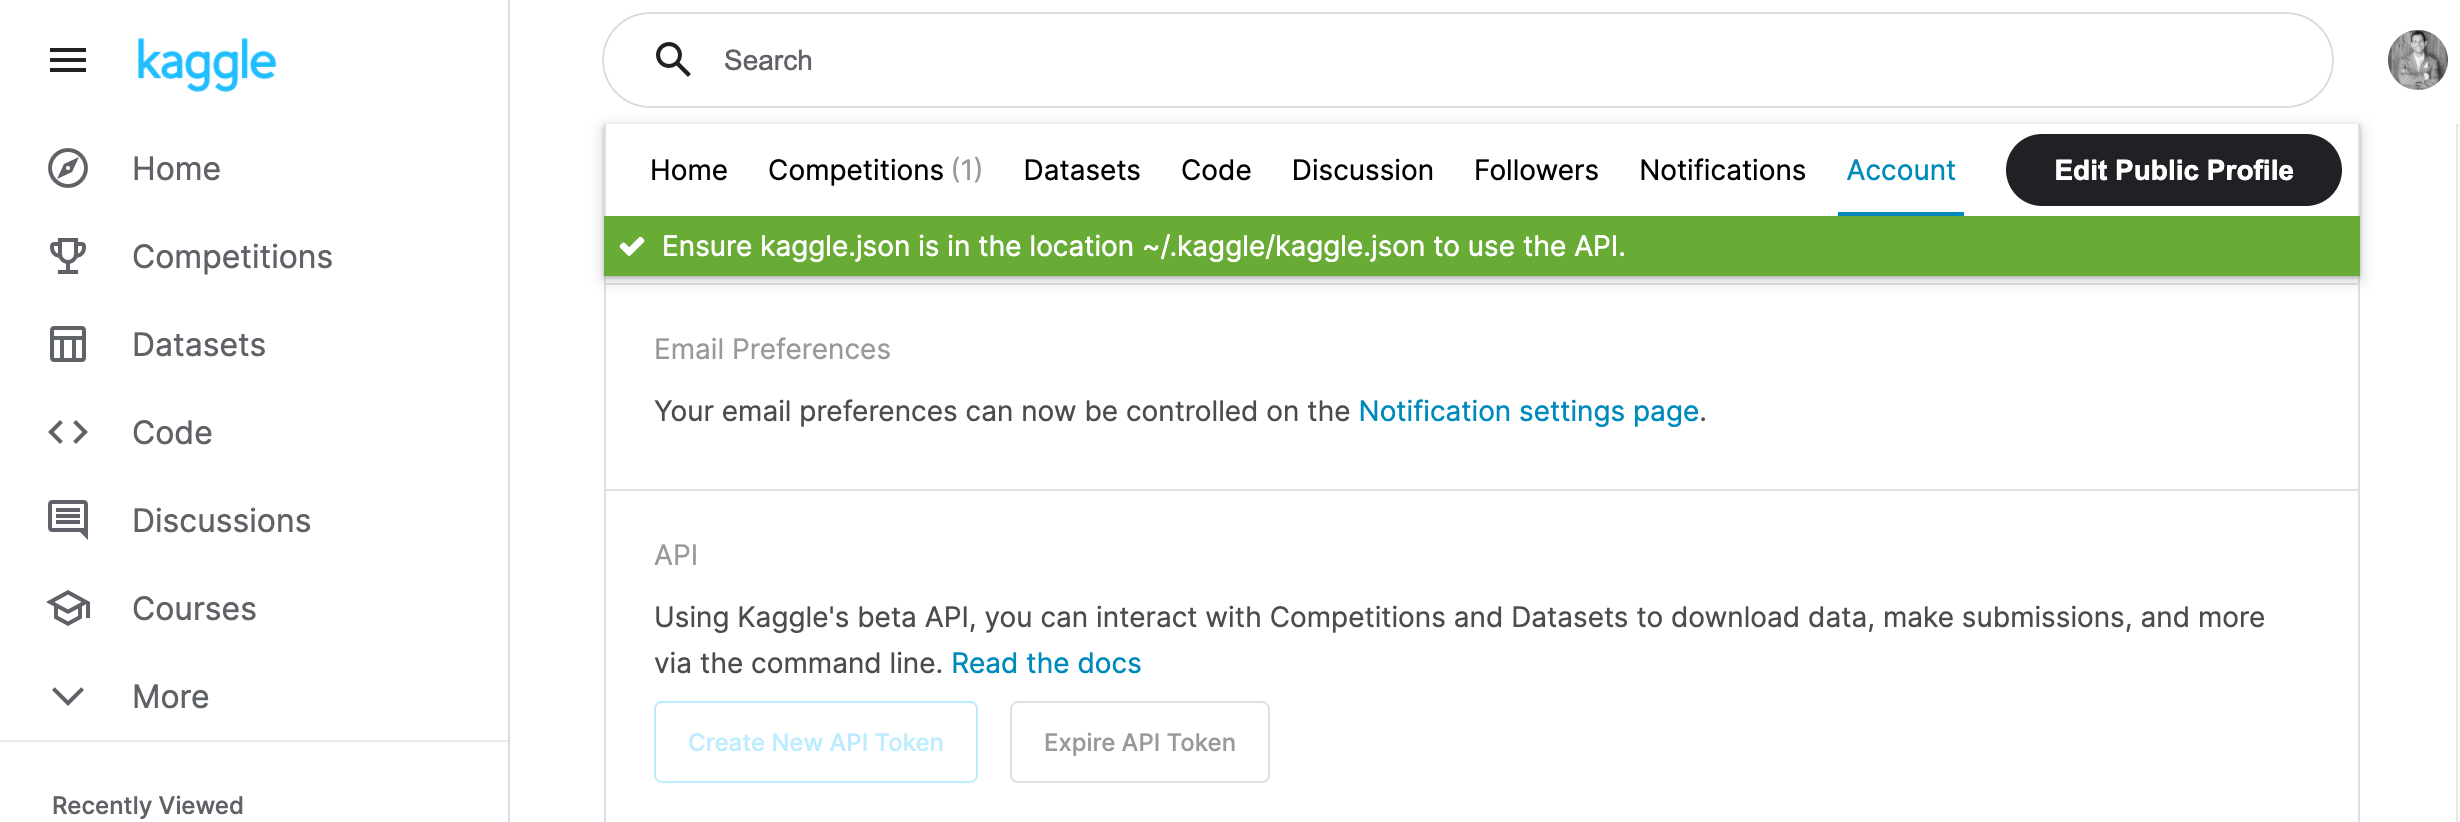
3. Open up `kaggle.json` and use the username and key.
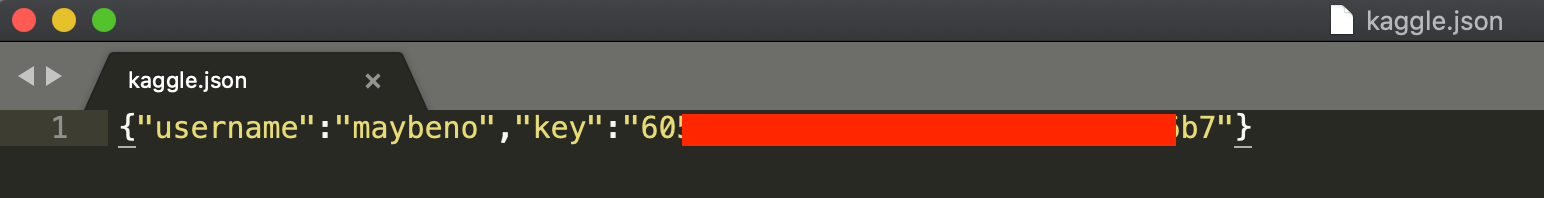

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install kaggle

In [3]:
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/nfl-player-contact-detection                  2023-03-01 23:59:00  Featured          $100,000        331           False  
https://www.kaggle.com/competitions/nfl-big-data-bowl-2023                        2023-01-09 23:59:00  Analytics         $100,000          0           False  
https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting     2023-03-14 23:59:00  Featured           $60,000        926           False  
https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations  2023-03-14 23:59:00  Featured           $55,000        280           False  
https://www.kaggle.com/competitions/santa-2022

In [4]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [5]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "FILL_IN_USERNAME"
kaggle_key = "FILL_IN_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
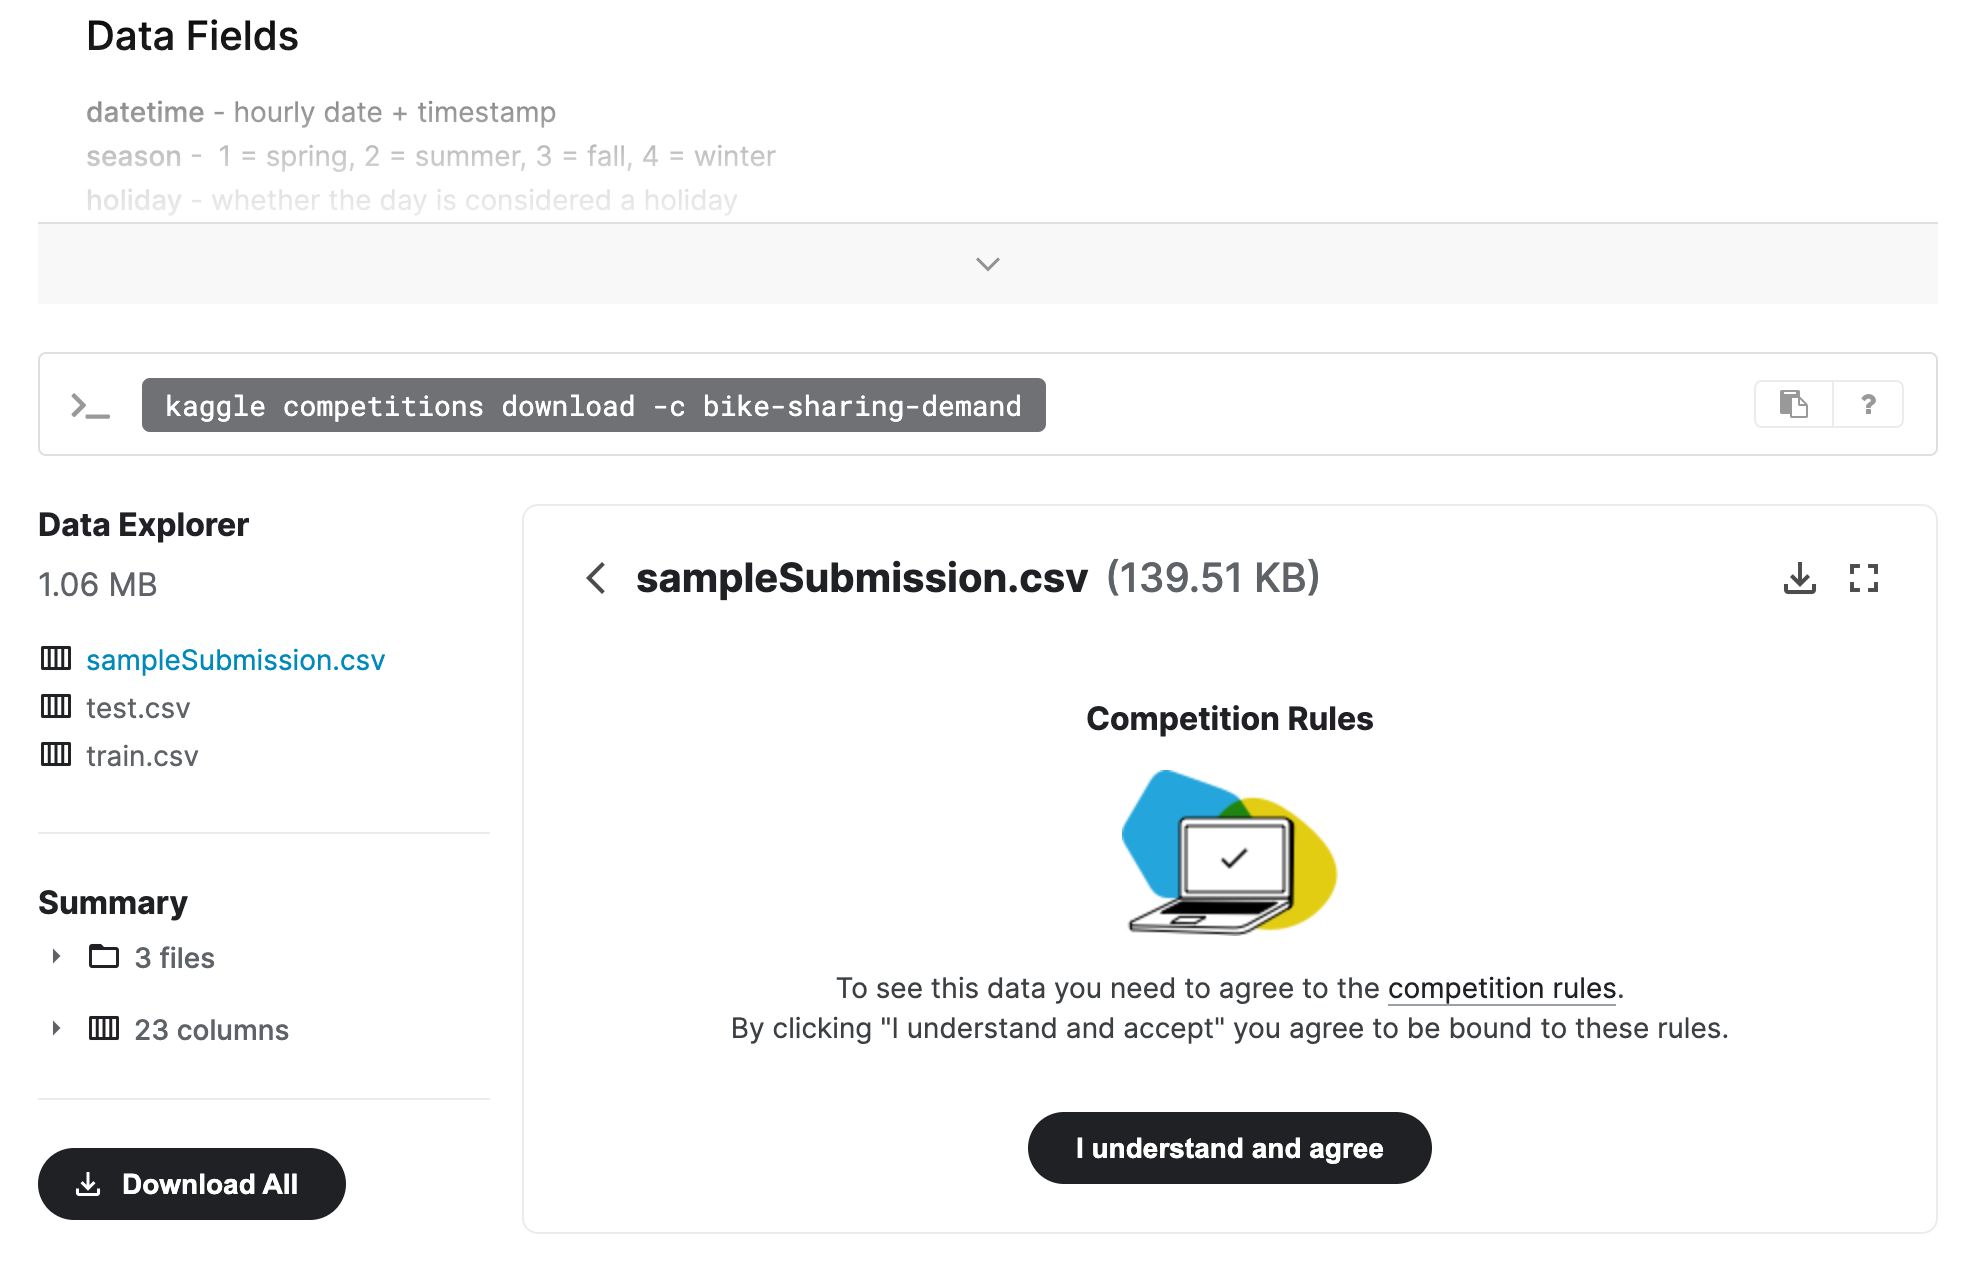

In [7]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [8]:
!pip install ipywidgets
!pip install pydantic==1.10.3


# **Context**
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

# **Objective**
You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.



# **Data Fields**
- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** - 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

In [9]:
import pandas as pd
import numpy as np       
import seaborn as sns
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor

In [10]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates = ["datetime"])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [11]:
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [13]:
train.corr()

season   holiday  workingday   weather      temp     atemp  \
season      1.000000  0.029368   -0.008126  0.008879  0.258689  0.264744   
holiday     0.029368  1.000000   -0.250491 -0.007074  0.000295 -0.005215   
workingday -0.008126 -0.250491    1.000000  0.033772  0.029966  0.024660   
weather     0.008879 -0.007074    0.033772  1.000000 -0.055035 -0.055376   
temp        0.258689  0.000295    0.029966 -0.055035  1.000000  0.984948   
atemp       0.264744 -0.005215    0.024660 -0.055376  0.984948  1.000000   
humidity    0.190610  0.001929   -0.010880  0.406244 -0.064949 -0.043536   
windspeed  -0.147121  0.008409    0.013373  0.007261 -0.017852 -0.057473   
casual      0.096758  0.043799   -0.319111 -0.135918  0.467097  0.462067   
registered  0.164011 -0.020956    0.119460 -0.109340  0.318571  0.314635   
count       0.163439 -0.005393    0.011594 -0.128655  0.394454  0.389784   

            humidity  windspeed    casual  registered     count  
season      0.190610  -0.147121  0.096758    0.164011  0.163439  
holiday     0.001929   0.008409  0.043799   -0.020956 -0.005393  
workingday -0.010880   0.013373 -0.319111    0.119460  0.011594  
weather     0.406244   0.007261 -0.135918   -0.109340 -0.128655  
temp       -0.064949  -0.017852  0.467097    0.318571  0.394454  
atemp      -0.043536  -0.057473  0.462067    0.314635  0.389784  
humidity    1.000000  -0.318607 -0.348187   -0.265458 -0.317371  
windspeed  -0.318607   1.000000  0.092276    0.091052  0.101369  
casual     -0.348187   0.092276  1.000000    0.497250  0.690414  
registered -0.265458   0.091052  0.497250    1.000000  0.970948  
count      -0.317371   0.101369  0.690414    0.970948  1.000000

In [14]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [15]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates = ["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [16]:
test.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [18]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates = ["datetime"])
submission.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [19]:
#to drop casual and registered columns
df_train_col = train.columns.to_list()
df_train = train.drop (['casual', 'registered'], axis =1)
df_train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  count  
0        81        0.0     16  
1        80        0.0     40  
2        80        0.0     32  
3        75        0.0     13  
4        75        0.0      1

In [20]:
predictor = TabularPredictor(
    label = "count", 
    problem_type = "regression",
    eval_metric = "rmse"
    ).fit(train_data = df_train,
    time_limit = 600,
    presets = 'best_quality',)

No path specified. Models will be saved in: "AutogluonModels/ag-20230105_003239/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230105_003239/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3161.25 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

### Review AutoGluon's training run with ranking of models that did the best.

In [21]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.813217      11.801118  437.384291                0.000978           0.342797            3       True         15
1   RandomForestMSE_BAG_L2  -53.332720      10.953581  406.203987                0.593252          26.920486            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.959640      10.957476  387.547928                0.597147           8.264428            2       True         14
3          LightGBM_BAG_L2  -55.042868      10.609740  401.856580                0.249411          22.573079            2       True         11
4          CatBoost_BAG_L2  -55.671233      10.459227  445.372361                0.098897          66.088860            2       True         13
5        LightGBMXT_BAG_L2  -60.310653      13.815688  431.536325         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [22]:
predictions = predictor.predict(test, as_pandas = True)
predictions.head()

0    23.196625
1    40.816895
2    44.257828
3    47.964020
4    50.980766
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [23]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.658150
std        90.117188
min         2.990258
25%        20.380848
50%        63.159340
75%       169.969330
max       366.873566
Name: count, dtype: float64

In [24]:
# How many negative values do we have?
(predictions < 0). sum()

0

In [25]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [26]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 338kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [28]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                              date                 description                                       status    publicScore  privateScore  
------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
submission.csv                        2023-01-05 00:43:16  first raw submission                              complete  1.80731      1.80731       
submission_new_features.csv           2023-01-05 00:23:31  new features                                      complete  0.48905      0.48905       
submission.csv                        2023-01-05 00:12:05  first raw submission                              complete  1.80745      1.80745       
submission_new_features.csv           2023-01-04 23:52:09  new features                                      complete  0.48888      0.48888       
tail: write error: Broken pipe


#### Initial score of `1.80731`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

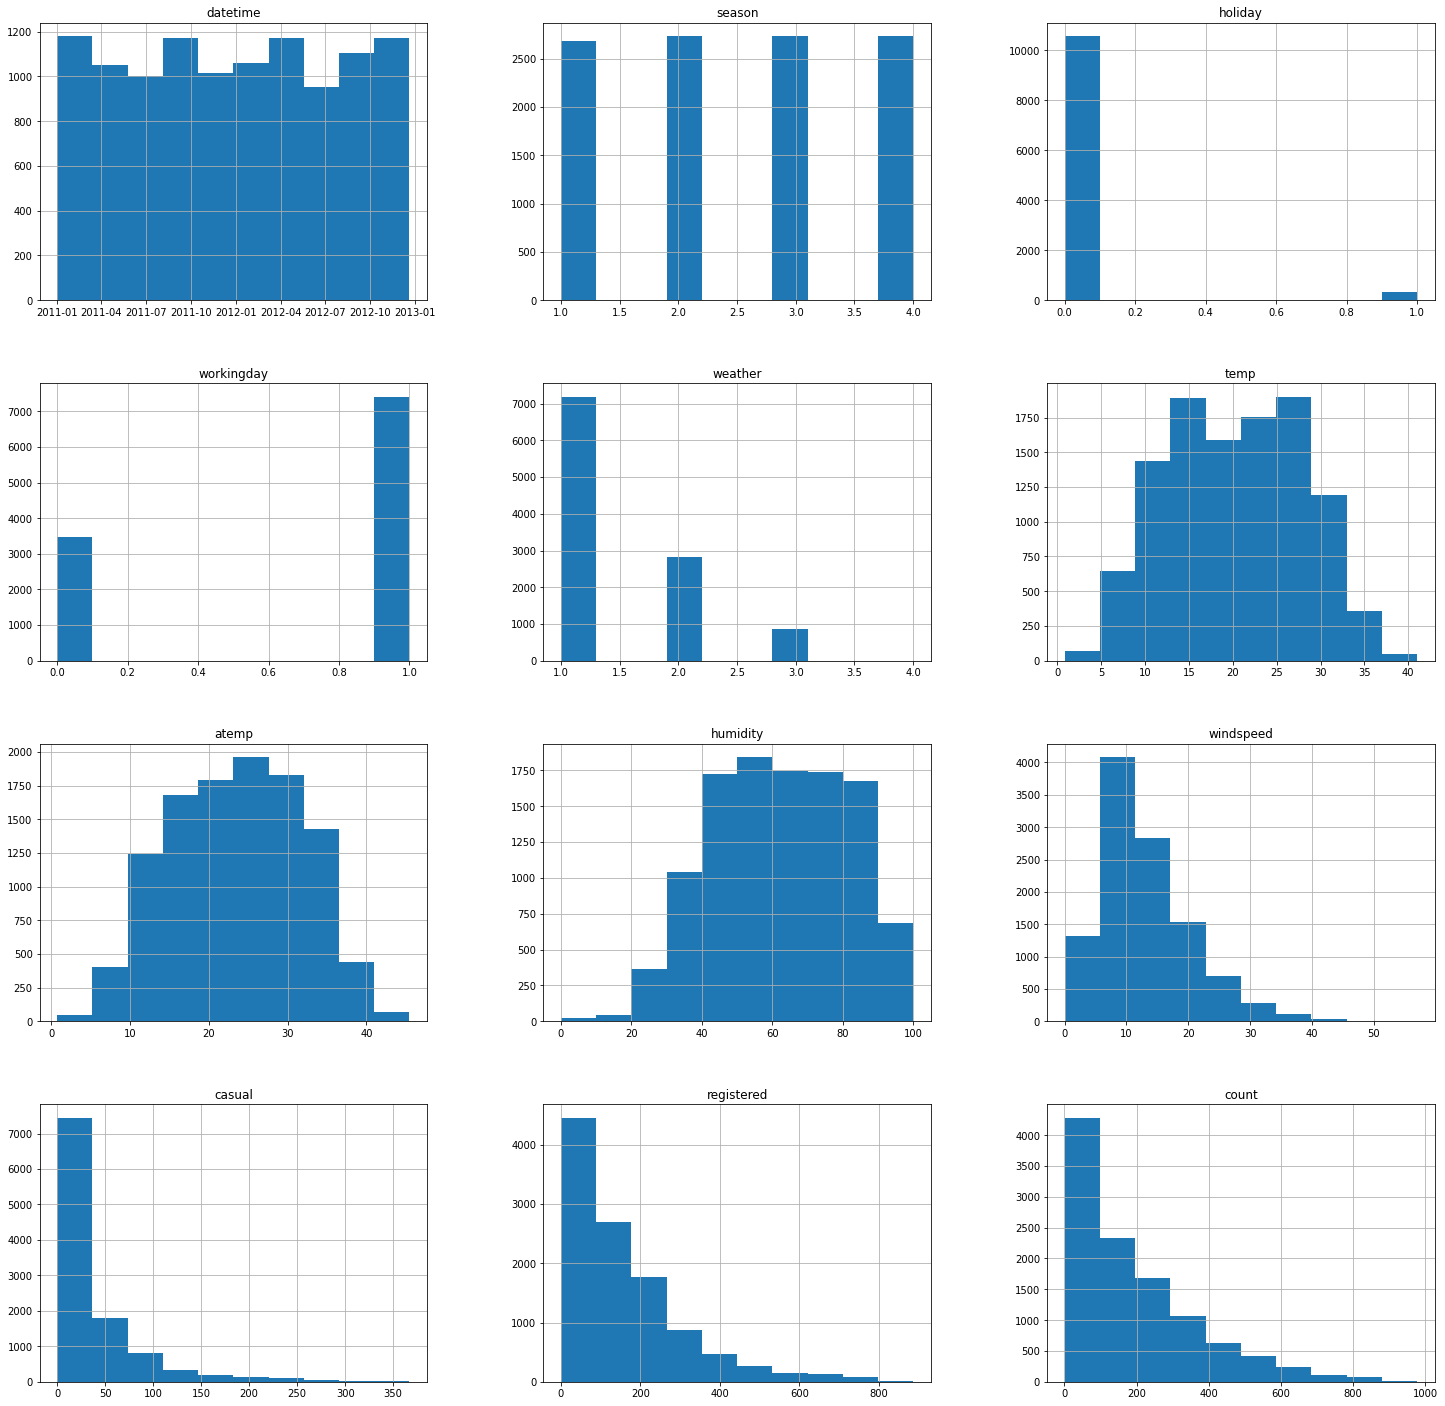

In [29]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(25,25))

In [30]:
train['datetime'].value_counts()

2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: datetime, Length: 10886, dtype: int64

In [31]:
#getting unique hour values in the year column
train.datetime.dt.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [32]:
#getting unique hour values in the year column
test.datetime.dt.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [33]:
#getting unique day values in the year column
train.datetime.dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [34]:
#getting unique day values in the year column
test.datetime.dt.day.unique()

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [35]:
#getting unique values in the year column
train.datetime.dt.year.unique()

array([2011, 2012])

In [36]:
#getting unique values in the year column
test.datetime.dt.year.unique()

array([2011, 2012])

In [37]:
# create new features
train["hour"] = train.datetime.dt.hour
test["hour"] = test.datetime.dt.hour

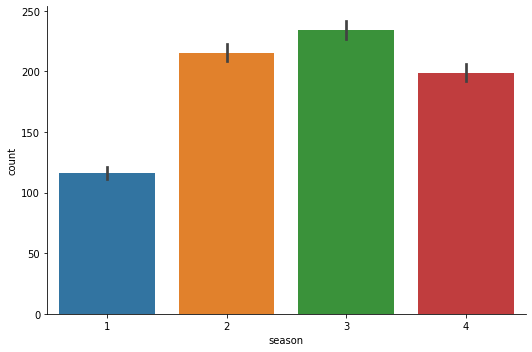

In [38]:
#Lets plot season against count
sns.catplot(x="season", y="count", data=train, kind='bar', height=5, aspect=1.5, estimator=np.mean);

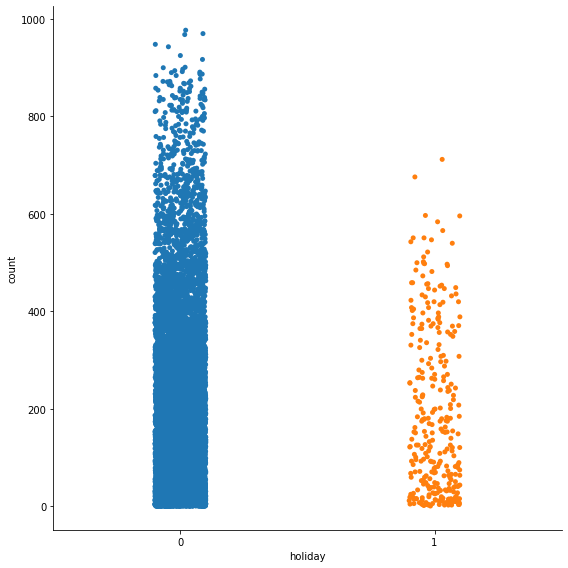

In [39]:
#Lets plot count against holiday
sns.catplot(x="holiday", y="count", data=train, height=8, aspect=1., estimator=np.mean);

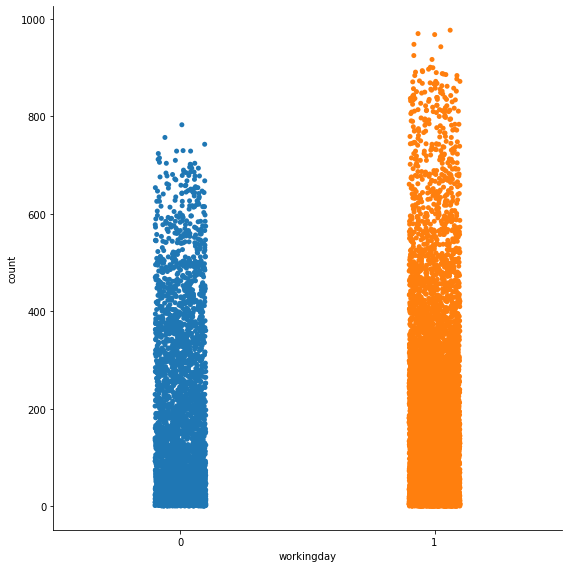

In [40]:
#Lets plot count against workingday
sns.catplot(x="workingday", y="count", data=train, height=8, aspect=1., estimator=np.mean);

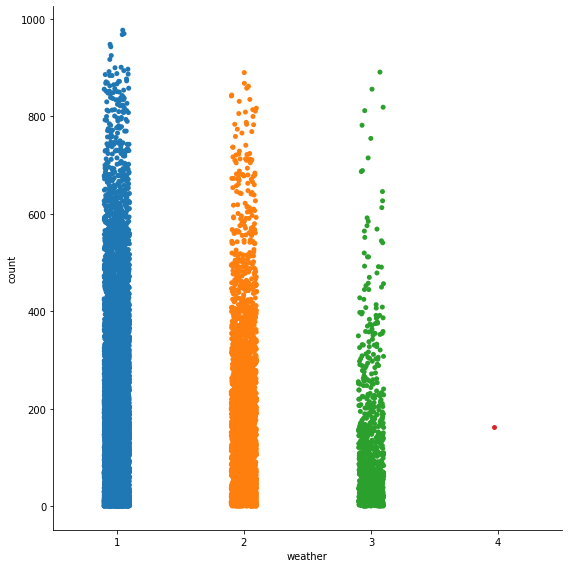

In [41]:
#Lets plot count against weather
sns.catplot(x="weather", y="count", data=train, height=8, aspect=1., estimator=np.mean);

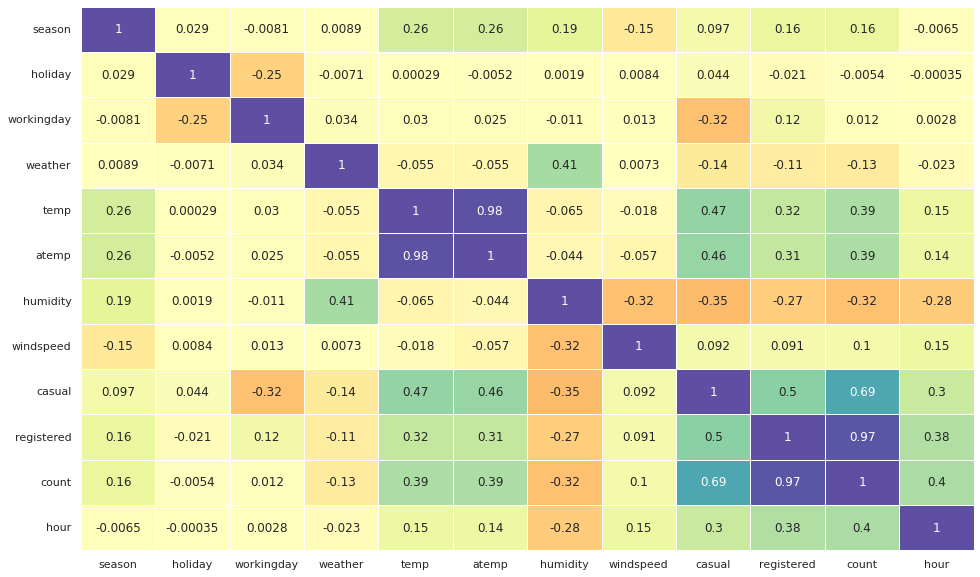

In [42]:
#Plotting a heatmap
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(train.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

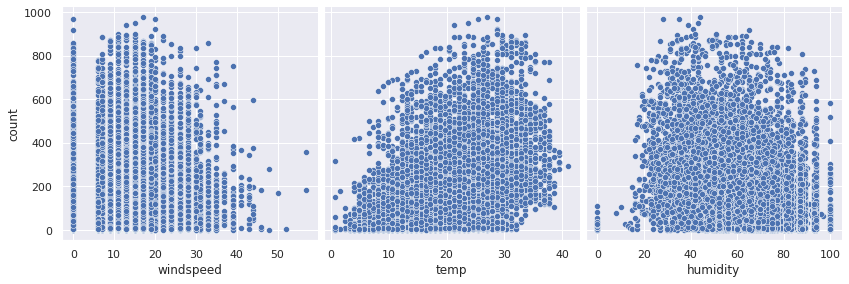

In [43]:
sns.pairplot(
    train,
    x_vars=["windspeed", "temp", "humidity"],
    y_vars=["count"],
    height=4,
    aspect=1
    );

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [44]:
train["season"] = train.season.astype("category")
train["weather"] = train.weather.astype("category")
test["season"] = test.season.astype("category")
test["weather"] = test.weather.astype("category")

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>]],
      dtype=object)

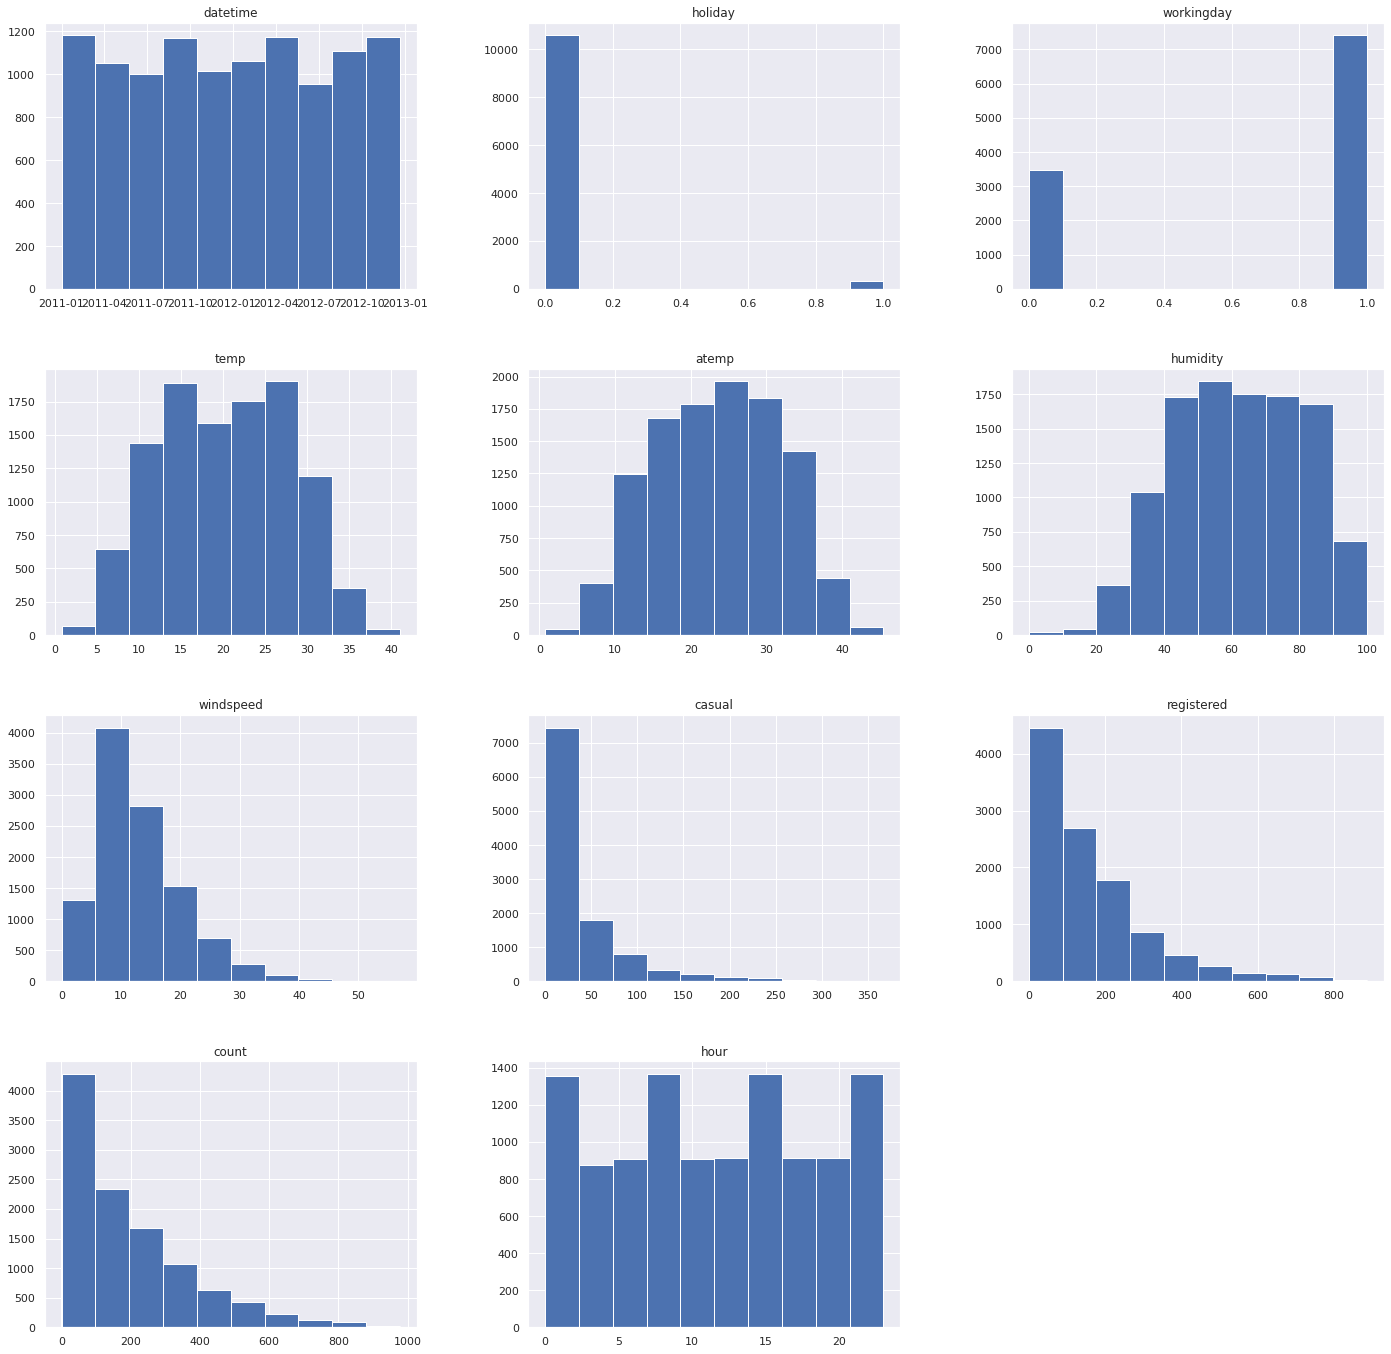

In [45]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(24,24))

## Step 5: Rerun the model with the same settings as before, just with more features

In [46]:
#to drop casual and registered columns
df_train_new_features_col = train.columns.to_list()
df_train_new_features = train.drop (['casual', 'registered'], axis =1)
df_train_new_features.head()

datetime season  holiday  workingday weather  temp   atemp  \
0 2011-01-01 00:00:00      1        0           0       1  9.84  14.395   
1 2011-01-01 01:00:00      1        0           0       1  9.02  13.635   
2 2011-01-01 02:00:00      1        0           0       1  9.02  13.635   
3 2011-01-01 03:00:00      1        0           0       1  9.84  14.395   
4 2011-01-01 04:00:00      1        0           0       1  9.84  14.395   

   humidity  windspeed  count  hour  
0        81        0.0     16     0  
1        80        0.0     40     1  
2        80        0.0     32     2  
3        75        0.0     13     3  
4        75        0.0      1     4

In [47]:
predictor_new_features = TabularPredictor(
    label = "count", 
    problem_type = "regression", 
    eval_metric = "rmse"
    ).fit(
    train_data = df_train_new_features,
    time_limit = 600, presets = "best_quality",
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20230105_004325/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230105_004325/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 10
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2176.66 MB
	Train Data (Original)  Memory Usage: 0.72 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note

In [48]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.132846      21.905995  558.650520                0.000690           0.318314            3       True         15
1          CatBoost_BAG_L2  -30.360208      19.948344  478.064987                0.104733          81.882311            2       True         13
2          LightGBM_BAG_L2  -30.580796      20.242956  420.218751                0.399344          24.036075            2       True         11
3        LightGBMXT_BAG_L2  -31.202995      20.794505  423.950432                0.950894          27.767755            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.418762      20.508681  404.677394                0.665070           8.494717            2       True         14
5   RandomForestMSE_BAG_L2  -31.568485      20.450334  424.646066         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.457273921492806,
  'LightGBM_BAG_L1': -

<AxesSubplot:xlabel='model'>

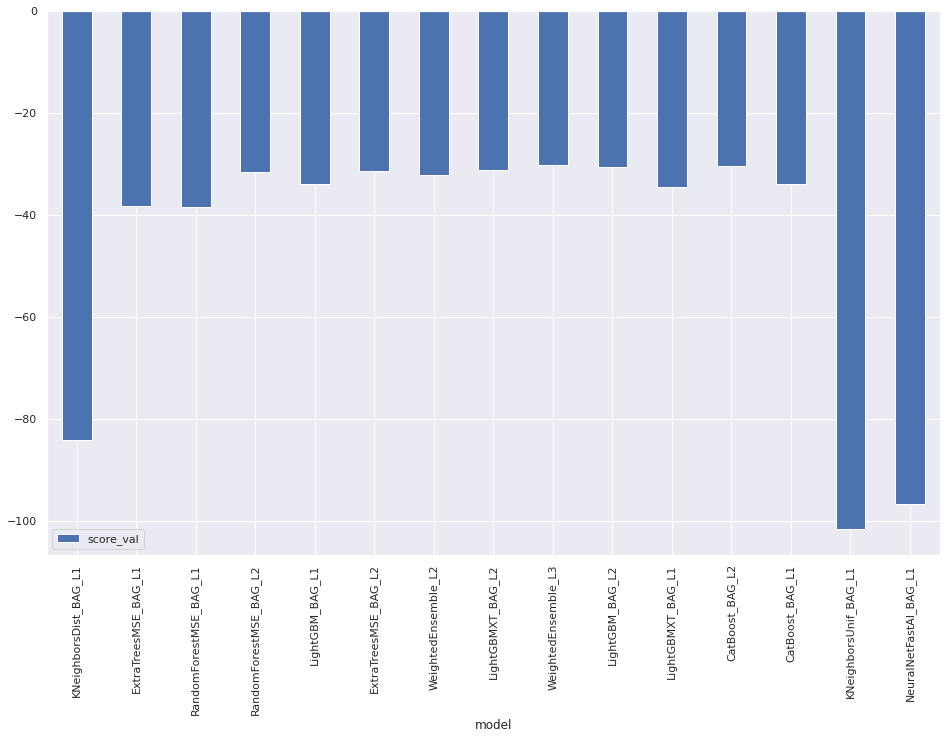

In [49]:
predictor_new_features.leaderboard(df_train_new_features, silent=True).plot(kind='bar', x='model', y='score_val')

In [50]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test, as_pandas=True)
(predictions_new_features < 0).sum()

0

In [51]:
predictions_new_features[predictions_new_features < 0] = 0

In [52]:
# Same submitting predictions
submission_new_features = pd.read_csv('submission.csv')
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [53]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 369kB/s]
Successfully submitted to Bike Sharing Demand

In [54]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                              date                 description                                       status    publicScore  privateScore  
------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
submission_new_features.csv           2023-01-05 00:55:43  new features                                      complete  0.69094      0.69094       
submission.csv                        2023-01-05 00:43:16  first raw submission                              complete  1.80731      1.80731       
submission_new_features.csv           2023-01-05 00:23:31  new features                                      complete  0.48905      0.48905       
submission.csv                        2023-01-05 00:12:05  first raw submission                              complete  1.80745      1.80745       
tail: write error: Broken pipe


#### New Score of `0.69094`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [55]:
import autogluon.core as ag
# hyperparameter settings
gbm_options = {
    'num_boost_round' : ag.space.Int(lower=100, upper=250, default=100),
    'learning_rate' : ag.space.Real(lower=0.01, upper=0.3, log=True),
    'num_leaves' : ag.space.Int(lower=3, upper=5)
}


cat_options = {
    'iterations' : 100,
    'depth' : ag.space.Int(lower=6, upper=10),
    'learning_rate' : ag.space.Real(lower=0.01, upper=0.1, log=True)
}
xgb_options = {
    'n_estimators' : ag.space.Int(lower=100, upper=500, default=100),
    'eta' : ag.space.Real(lower=0.01, upper=0.3, log=True),
    'max_depth' : ag.space.Int(lower=3, upper=5, default=6)
}

In [56]:
# using specific hyperparameter options
# Models : GBM, CAT, XGB, RF, XT, KNN, LR, NN_MXNET, NN_TORCH
hyperparameters = {
    'XGB' : xgb_options,
    'GBM' : gbm_options,
    'CAT' : cat_options
}

num_trials = 5
search_strategy = 'random'

hyperparameter_tune_kwargs = {
    'num_trials' : num_trials,
    'scheduler' : 'local',
    'searcher' : search_strategy
}

In [57]:
predictor_new_hpo = TabularPredictor(
    label='count', 
    problem_type='regression', 
    eval_metric='root_mean_squared_error',
    path='AutogluonModels/xgb_gbm_cat_tuning_v1'
    ).fit(
    train_data=df_train_new_features, 
    time_limit=600, 
    presets='best_quality',
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    )

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/xgb_gbm_cat_tuning_v1/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 10
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2074.93 MB
	Train Data (Original)  Memory Usage: 0.72 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: LightGBM_BAG_L1/T1 ...
	-138.9213	 = Validation score   (-root_mean_squared_error)
	19.0s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-60.8263	 = Validation score   (-root_mean_squared_error)
	19.5s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-100.087	 = Validation score   (-root_mean_squared_error)
	18.83s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T4 ...
	-85.5628	 = Validation score   (-root_mean_squared_error)
	19.05s	 = Tr

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-112.9033	 = Validation score   (-root_mean_squared_error)
	19.9s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost_BAG_L1/T2 ...
	-40.3632	 = Validation score   (-root_mean_squared_error)
	26.72s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost_BAG_L1/T3 ...
	-57.0004	 = Validation score   (-root_mean_squared_error)
	23.18s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost_BAG_L1/T4 ...
	-42.818	 = Validation score   (

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
Fitted model: XGBoost_BAG_L1/T1 ...
	-38.0755	 = Validation score   (-root_mean_squared_error)
	17.01s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T2 ...
	-45.412	 = Validation score   (-root_mean_squared_error)
	19.75s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T3 ...
	-119.061	 = Validation score   (-root_mean_squared_error)
	20.05s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T4 ...
	-44.6443	 = Validation score   (-root_mean_squared_error)
	21.06s	 = Traini

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-88.6609	 = Validation score   (-root_mean_squared_error)
	20.0s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-36.9692	 = Validation score   (-root_mean_squared_error)
	20.05s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T3 ...
	-37.6111	 = Validation score   (-root_mean_squared_error)
	19.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T4 ...
	-37.4203	 = Validation score   (-root_mean_squared_error)
	20.29s	 = Training   runtime
	0.0s	 = Validation runtime
Hy

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	-80.1486	 = Validation score   (-root_mean_squared_error)
	23.18s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost_BAG_L2/T2 ...
	-36.968	 = Validation score   (-root_mean_squared_error)
	58.41s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L2 ... Tuning model for up to 87.54s of the 129.49s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L2/T1 ...
	-36.537	 = Validation score   (-root_mean_squared_error)
	20.08s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T2 ...
	-36.4219	 = Validation score   (-root_mean_squared_error)
	26.2s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T3 ...
	-57.7791	 = Validation score   (-root_mean_squared_error)
	21.97s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 60.94s of remaining time.
	-36.1014	 = Validation score   (-root_mean_squared_error)
	0.48s	 = Training   runtime
	0.0s	 = Val

<AxesSubplot:xlabel='model'>

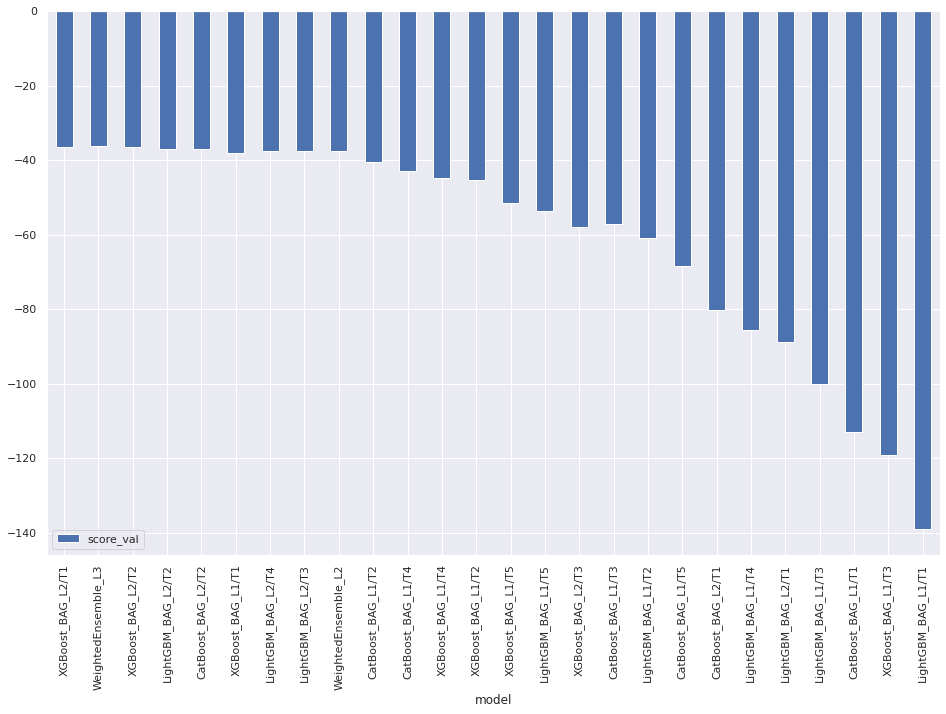

In [58]:
predictor_new_hpo.leaderboard(df_train_new_features, silent=True).plot(kind='bar', x='model', y='score_val')

In [59]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3  -36.101380       0.002707  410.923595                0.000776           0.478604            3       True         26
1     XGBoost_BAG_L2/T2  -36.421905       0.001711  331.959537                0.000119          26.198822            2       True         24
2     XGBoost_BAG_L2/T1  -36.537041       0.001725  325.838514                0.000134          20.077799            2       True         23
3    CatBoost_BAG_L2/T2  -36.967969       0.001677  364.168371                0.000086          58.407656            2       True         22
4    LightGBM_BAG_L2/T2  -36.969175       0.001686  325.807110                0.000095          20.046395            2       True         18
5    LightGBM_BAG_L2/T4  -37.420303       0.001702  326.045996                0.000111      

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L1/T2': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L1/T3': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L1/T4': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L1/T5': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T3': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T4': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T5': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM

In [60]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test, as_pandas=True)
(predictions_new_hpo < 0).sum()

0

In [61]:
# Same submitting predictions
submission_new_hpo = submission
submission_new_hpo["count"] = predictions_new_hpo


# submission_new_hpo['count'] = submission_new_hpo["count"].astype('int64')
submission_new_hpo.to_csv("submission_new_hpo_cat_gbm_xgb_2.csv", index=False)

In [62]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_cat_gbm_xgb_2.csv -m "new features with hyperparameters cat xgb gbm 2 "

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 337kB/s]
Successfully submitted to Bike Sharing Demand

In [63]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                              date                 description                                       status    publicScore  privateScore  
------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
submission_new_hpo_cat_gbm_xgb_2.csv  2023-01-05 01:05:05  new features with hyperparameters cat xgb gbm 2   complete  0.46771      0.46771       
submission_new_features.csv           2023-01-05 00:55:43  new features                                      complete  0.69094      0.69094       
submission.csv                        2023-01-05 00:43:16  first raw submission                              complete  1.80731      1.80731       
submission_new_features.csv           2023-01-05 00:23:31  new features                                      complete  0.48905      0.48905       
tail: write error: Broken pipe


#### New Score of `0.46771   `

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

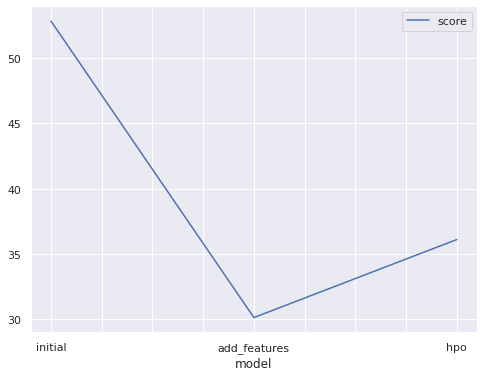

In [65]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [52.813217, 30.132846, 36.101380]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

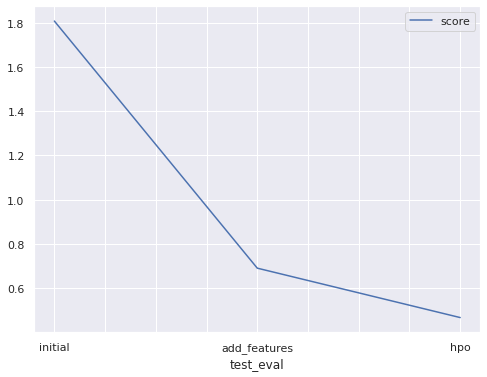

In [66]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80731, 0.69094, 0.46771]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [67]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [
        'default_vals', 
        'default_vals', 
        'GBM (Light gradient boosting) : num_boost_round: [lower=100, upper=25], learning_rate:[lower=0.01, upper=0.3, log scale],num_leaves:[lower=3, upper=5] applying random search with 5 trials'
        ],
    "hpo2": [
        'default_vals', 
        'default_vals', 
        'XGB (XGBoost): n_estimators : [lower=100, upper=500], max_depth : [lower=3, upper=5], eta (learning_rate) : [lower=0.01, upper=0.3, log scale] applying random search with 5 trials'
        ],
    "hpo3": [
        'default_vals', 
        'default_vals', 
        'CAT (CATBoost) : iterations : 100, depth : [lower=6, upper=10], learning_rate  : [lower=0.01, upper=0.1, log scale] applying random search with 5 trials'
    ],
    "score": [1.80731, 0.69094, 0.46771]
})


model  \
0       initial   
1  add_features   
2           hpo   

                                                                                                                                                                                          hpo1  \
0                                                                                                                                                                                 default_vals   
1                                                                                                                                                                                 default_vals   
2  GBM (Light gradient boosting) : num_boost_round: [lower=100, upper=25], learning_rate:[lower=0.01, upper=0.3, log scale],num_leaves:[lower=3, upper=5] applying random search with 5 trials   

                                                                                                                                                                                  hpo2  \
0                                                                                                                                                                         default_vals   
1                                                                                                                                                                         default_vals   
2  XGB (XGBoost): n_estimators : [lower=100, upper=500], max_depth : [lower=3, upper=5], eta (learning_rate) : [lower=0.01, upper=0.3, log scale] applying random search with 5 trials   

                                                                                                                                                       hpo3  \
0                                                                                                                                              default_vals   
1                                                                                                                                              default_vals   
2  CAT (CATBoost) : iterations : 100, depth : [lower=6, upper=10], learning_rate  : [lower=0.01, upper=0.1, log scale] applying random search with 5 trials   

     score  
0  1.80731  
1  0.69094  
2  0.46771